# GBM Quantile Regression Exit Model

This notebook trains **Gradient Boosted quantile regressors** to predict dynamic exit levels
for mean reversion trades. The models predict:

- **0.1 quantile (10th percentile)**: Stop-loss level
- **0.5 quantile (median)**: Profit target level

We train on events predicted by the Random Forest to revert with high probability (RF proba >= 0.5),
using a **day-level LODO scheme** on the four training days (Oct 2, 3, 6, 7) and evaluate on
the held-out test day (Oct 8).

**Evaluation Metrics:**
- Quantile Loss (Pinball Loss)
- Coverage Rates
- Calibration

In [1]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

os.chdir('..')
print(f"Working directory: {os.getcwd()}")

from src.gbm.data import load_rf_scores, compute_forward_returns, prepare_gbm_dataset
from src.gbm.model import train_quantile_gbm, tune_and_train_gbm, save_artifacts
from src.gbm.evaluate import (
    pinball_loss, coverage_rate, calibration_metrics, 
    compute_all_metrics, compute_interval_metrics, summarize_cv_results
)

# Config
RANDOM_STATE = 42
RF_PROBA_THRESHOLD = 0.3
DATA_PATH = Path("data/randomForest/rf_opportunity_scores.parquet")

logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")
logger = logging.getLogger("gbm_notebook")

np.random.seed(RANDOM_STATE)

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 100

Working directory: c:\Users\doqui\OneDrive\Documents\cs4641-131-project


## 1. Load RF Opportunity Scores

In [2]:
# Load the RF opportunity scores
df = load_rf_scores(DATA_PATH, processed_dir="data/processed", logger=logger)

print(f"Columns: {list(df.columns)}")
print(f"\nShape: {df.shape}")
display(df.head(3))

2025-11-28 14:36:38,071 [INFO] Loaded RF scores: 2,347 rows from data\randomForest\rf_opportunity_scores.parquet
2025-11-28 14:36:38,072 [INFO] Loading ewm_std from processed data...
2025-11-28 14:36:38,790 [INFO] Loaded 46,855 rows from processed data
2025-11-28 14:36:38,840 [INFO] Merged ewm_std: 2,347 rows have ewm_std


Columns: ['ticker', 'date', 't', 't_end', 'gmm_loglik', 'gmm_is_candidate', 'gmm_component', 'label', 'feat_vwap_zscore', 'feat_bollinger_position', 'feat_momentum_3bar', 'feat_momentum_5bar', 'feat_relative_volume', 'feat_time_of_day', 'feat_context_bar_count', 'feat_context_avg_volume', 'feat_context_price_range', 'day', 'y', 'rf_proba_reversion', 'ewm_std']

Shape: (2347, 21)


,ticker,date,t,t_end,gmm_loglik,gmm_is_candidate,gmm_component,label,feat_vwap_zscore,feat_bollinger_position,...,feat_momentum_5bar,feat_relative_volume,feat_time_of_day,feat_context_bar_count,feat_context_avg_volume,feat_context_price_range,day,y,rf_proba_reversion,ewm_std
0,CCL,2025-10-02,2025-10-02 13:36:05+00:00,2025-10-02 13:36:24+00:00,-17.999703,True,2,1,0.864960,0.600875,...,0.004230,0.396659,0.003009,5.0,12091.000000,0.005090,2025-10-02,1,0.747043,0.000936
1,CCL,2025-10-02,2025-10-02 13:36:26+00:00,2025-10-02 13:37:03+00:00,-18.499216,True,2,1,-1.860753,-0.175962,...,0.000352,0.425833,0.003981,6.0,10875.166992,0.005804,2025-10-02,1,0.792892,0.000891
2,CCL,2025-10-02,2025-10-02 13:37:03+00:00,2025-10-02 13:37:27+00:00,-17.062258,True,2,1,1.760251,0.679791,...,0.001405,0.473198,0.005694,7.0,9983.142578,0.006316,2025-10-02,1,0.780603,0.001453


In [3]:
# Check for required columns
required = ["label", "ewm_std", "rf_proba_reversion"]
missing = [c for c in required if c not in df.columns]
if missing:
    print(f"WARNING: Missing columns: {missing}")
else:
    print("All required columns present.")

# Summary of RF probabilities
print(f"\nRF probability distribution:")
print(df["rf_proba_reversion"].describe())

All required columns present.

RF probability distribution:
count    2347.000000
mean        0.500263
std         0.221240
min         0.003950
25%         0.317948
50%         0.493679
75%         0.692778
max         0.978781
Name: rf_proba_reversion, dtype: float64


## 2. Compute Forward Returns

In [4]:
# Compute forward returns as the target variable
df = compute_forward_returns(df, logger=logger)

print(f"\nForward return distribution:")
print(df["forward_return"].describe())

2025-11-28 14:36:38,929 [INFO] Forward return stats: mean=0.000024, std=0.001297, min=-0.006855, max=0.003871
2025-11-28 14:36:38,934 [INFO]   Label -1: n=1102, mean=-0.001171, std=0.000743
2025-11-28 14:36:38,939 [INFO]   Label +0: n=47, mean=0.000000, std=0.000000
2025-11-28 14:36:38,941 [INFO]   Label +1: n=1198, mean=0.001124, std=0.000514



Forward return distribution:
count    2347.000000
mean        0.000024
std         0.001297
min        -0.006855
25%        -0.000971
50%         0.000449
75%         0.001046
max         0.003871
Name: forward_return, dtype: float64


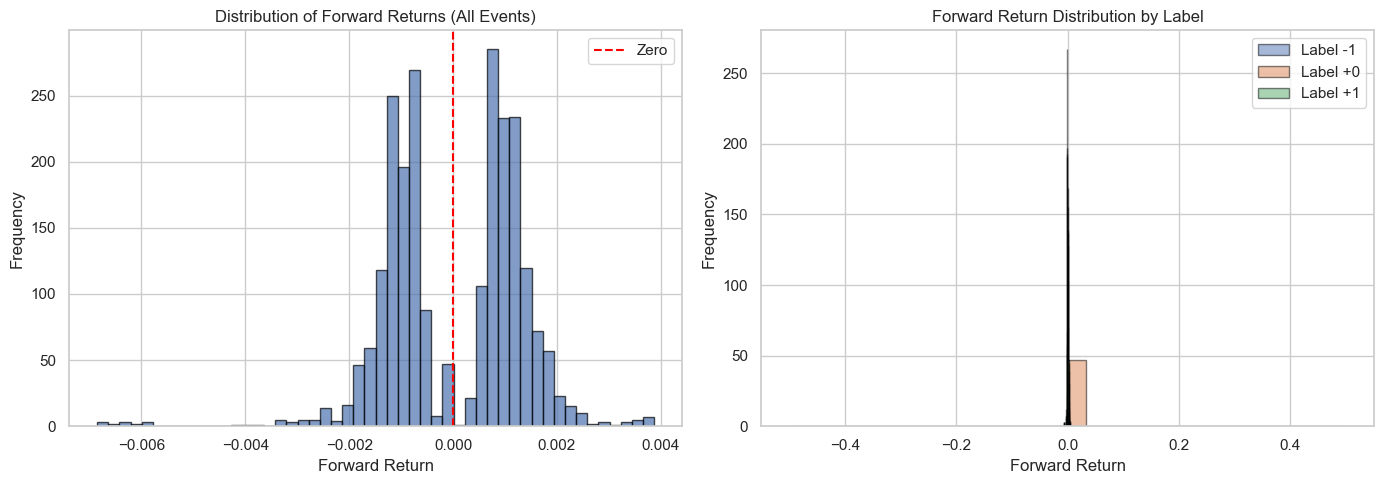

In [5]:
# Visualize forward return distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
ax.hist(df["forward_return"].dropna(), bins=50, edgecolor="black", alpha=0.7)
ax.axvline(0, color="red", linestyle="--", label="Zero")
ax.set_xlabel("Forward Return")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Forward Returns (All Events)")
ax.legend()

# By label
ax = axes[1]
for label in sorted(df["label"].unique()):
    subset = df[df["label"] == label]["forward_return"].dropna()
    ax.hist(subset, bins=30, alpha=0.5, label=f"Label {label:+d}", edgecolor="black")
ax.set_xlabel("Forward Return")
ax.set_ylabel("Frequency")
ax.set_title("Forward Return Distribution by Label")
ax.legend()

plt.tight_layout()
plt.show()

## 3. Prepare GBM Dataset

In [6]:
# Prepare dataset: filter by RF probability, split by day, scale features
data = prepare_gbm_dataset(
    df,
    rf_proba_threshold=RF_PROBA_THRESHOLD,
    logger=logger,
)

X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]
scaler = data["scaler"]
train_day_groups = data["train_day_groups"]
feature_names = data["feature_names"]
train_days = data["train_days"]
test_day = data["test_day"]

print(f"\nDataset summary:")
print(f"  Train samples: {X_train.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")
print(f"  Features: {X_train.shape[1]}")
print(f"  Train days: {[str(d) for d in train_days]}")
print(f"  Test day: {test_day}")

print(f"\nTrain target stats: mean={y_train.mean():.6f}, std={y_train.std():.6f}")
print(f"Test target stats:  mean={y_test.mean():.6f}, std={y_test.std():.6f}")

2025-11-28 14:36:40,298 [INFO] Filtered to RF proba >= 0.30: 2347 -> 1841 rows (78.4% retained)
2025-11-28 14:36:40,300 [INFO] Using 9 features: ['feat_vwap_zscore', 'feat_bollinger_position', 'feat_momentum_3bar', 'feat_momentum_5bar', 'feat_relative_volume', 'feat_time_of_day', 'feat_context_bar_count', 'feat_context_avg_volume', 'feat_context_price_range']
2025-11-28 14:36:40,305 [INFO] Train days: ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07'] | Test day: 2025-10-08
2025-11-28 14:36:40,311 [INFO] Train samples: 1,424 | Test samples: 417
2025-11-28 14:36:40,318 [INFO] Standardized features using StandardScaler (fit on train)



Dataset summary:
  Train samples: 1,424
  Test samples: 417
  Features: 9
  Train days: ['2025-10-02', '2025-10-03', '2025-10-06', '2025-10-07']
  Test day: 2025-10-08

Train target stats: mean=0.000405, std=0.001222
Test target stats:  mean=0.000067, std=0.001036


## 4. Hyperparameter Tuning via LODO CV

We tune both the 0.1 quantile (stop-loss) and 0.5 quantile (target) models using Leave-One-Day-Out cross-validation.

In [7]:
# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [10, 20],
}

print("Hyperparameter grid:")
for k, v in param_grid.items():
    print(f"  {k}: {v}")

n_configs = 1
for v in param_grid.values():
    n_configs *= len(v)
print(f"\nTotal configurations to evaluate: {n_configs}")

Hyperparameter grid:
  n_estimators: [100, 200]
  max_depth: [3, 5]
  learning_rate: [0.05, 0.1]
  min_samples_leaf: [10, 20]

Total configurations to evaluate: 16


In [8]:
# Tune and train Q10 model (stop-loss)
print("=" * 60)
print("Tuning Q10 (Stop-Loss) Model")
print("=" * 60)

model_q10, summary_q10 = tune_and_train_gbm(
    X_train, y_train,
    day_groups=train_day_groups,
    quantile=0.1,
    param_grid=param_grid,
    logger=logger,
)

print(f"\nBest params (Q10): {summary_q10['best_params']}")
print(f"CV mean pinball: {summary_q10['cv_mean_pinball']:.6f} ± {summary_q10['cv_std_pinball']:.6f}")
print(f"Train pinball: {summary_q10['train_pinball']:.6f}")

2025-11-28 14:36:40,386 [INFO] Tuning GBM (quantile=0.10) via LODO CV on 4 days


Tuning Q10 (Stop-Loss) Model


2025-11-28 14:38:18,641 [INFO] Best GBM params (q=0.10): {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'min_samples_leaf': 20} | CV mean pinball=0.000202 ± 0.000005



Best params (Q10): {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'min_samples_leaf': 20}
CV mean pinball: 0.000202 ± 0.000005
Train pinball: 0.000177


In [9]:
# Tune and train Q50 model (target)
print("=" * 60)
print("Tuning Q50 (Target) Model")
print("=" * 60)

model_q50, summary_q50 = tune_and_train_gbm(
    X_train, y_train,
    day_groups=train_day_groups,
    quantile=0.5,
    param_grid=param_grid,
    logger=logger,
)

print(f"\nBest params (Q50): {summary_q50['best_params']}")
print(f"CV mean pinball: {summary_q50['cv_mean_pinball']:.6f} ± {summary_q50['cv_std_pinball']:.6f}")
print(f"Train pinball: {summary_q50['train_pinball']:.6f}")

2025-11-28 14:38:20,708 [INFO] Tuning GBM (quantile=0.50) via LODO CV on 4 days


Tuning Q50 (Target) Model


2025-11-28 14:40:00,051 [INFO] Best GBM params (q=0.50): {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'min_samples_leaf': 20} | CV mean pinball=0.000469 ± 0.000066



Best params (Q50): {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'min_samples_leaf': 20}
CV mean pinball: 0.000469 ± 0.000066
Train pinball: 0.000418


In [10]:
# Display CV results for both quantiles
print("\nQ10 Hyperparameter Tuning Results (Top 5):")
cv_df_q10 = summarize_cv_results(summary_q10["grid_results"], logger=logger)
display(cv_df_q10.head())

print("\nQ50 Hyperparameter Tuning Results (Top 5):")
cv_df_q50 = summarize_cv_results(summary_q50["grid_results"], logger=logger)
display(cv_df_q50.head())

2025-11-28 14:40:00,901 [INFO] CV results summary: 16 configurations evaluated



Q10 Hyperparameter Tuning Results (Top 5):


,n_estimators,max_depth,learning_rate,min_samples_leaf,quantile,cv_mean_pinball,cv_std_pinball
0,200,3,0.05,20,0.1,0.000202,0.000005
1,100,3,0.10,20,0.1,0.000203,0.000006
2,100,3,0.05,20,0.1,0.000203,0.000004
3,200,3,0.10,20,0.1,0.000203,0.000006
4,100,5,0.05,20,0.1,0.000204,0.000006


2025-11-28 14:40:00,915 [INFO] CV results summary: 16 configurations evaluated



Q50 Hyperparameter Tuning Results (Top 5):


,n_estimators,max_depth,learning_rate,min_samples_leaf,quantile,cv_mean_pinball,cv_std_pinball
0,100,3,0.05,20,0.5,0.000469,0.000066
1,100,3,0.05,10,0.5,0.000472,0.000061
2,100,3,0.10,10,0.5,0.000484,0.000052
3,200,3,0.05,20,0.5,0.000484,0.000054
4,200,3,0.05,10,0.5,0.000490,0.000060


## 5. Model Evaluation on Test Day

In [11]:
# Generate predictions
y_train_pred_q10 = model_q10.predict(X_train)
y_train_pred_q50 = model_q50.predict(X_train)

y_test_pred_q10 = model_q10.predict(X_test)
y_test_pred_q50 = model_q50.predict(X_test)

print("Predictions generated for train and test sets.")

Predictions generated for train and test sets.


In [12]:
# Compute all metrics for train
train_predictions = {0.1: y_train_pred_q10, 0.5: y_train_pred_q50}
train_metrics = compute_all_metrics(y_train, train_predictions, "train", logger=logger)

# Compute all metrics for test
test_predictions = {0.1: y_test_pred_q10, 0.5: y_test_pred_q50}
test_metrics = compute_all_metrics(y_test, test_predictions, "test", logger=logger)

2025-11-28 14:40:00,965 [INFO] train quantile 0.10: pinball=0.000177, coverage=0.098 (expected 0.10), calib_error=0.002
2025-11-28 14:40:00,968 [INFO] train quantile 0.50: pinball=0.000418, coverage=0.482 (expected 0.50), calib_error=0.018
2025-11-28 14:40:00,969 [INFO] test quantile 0.10: pinball=0.000133, coverage=0.096 (expected 0.10), calib_error=0.004
2025-11-28 14:40:00,970 [INFO] test quantile 0.50: pinball=0.000481, coverage=0.662 (expected 0.50), calib_error=0.162


In [13]:
# Summary table for report
metrics_rows = []

for split, metrics in [("train", train_metrics), ("test", test_metrics)]:
    for tau, qm in metrics["quantile_metrics"].items():
        metrics_rows.append({
            "Split": split,
            "Quantile": tau,
            "Pinball Loss": qm["pinball_loss"],
            "Coverage Rate": qm["coverage_rate"],
            "Expected Coverage": tau,
            "Calibration Error": qm["calibration_error"],
            "Residual Mean": qm["residual_mean"],
            "Residual Std": qm["residual_std"],
        })

metrics_df = pd.DataFrame(metrics_rows)
print("\nQuantile Regression Performance Summary:")
display(metrics_df)


Quantile Regression Performance Summary:


,Split,Quantile,Pinball Loss,Coverage Rate,Expected Coverage,Calibration Error,Residual Mean,Residual Std
0,train,0.1,0.000177,0.097612,0.1,0.002388,0.001576,0.001261
1,train,0.5,0.000418,0.482444,0.5,0.017556,-0.000508,0.001187
2,test,0.1,0.000133,0.095923,0.1,0.004077,0.001160,0.001063
3,test,0.5,0.000481,0.661871,0.5,0.161871,-0.000787,0.001040


In [14]:
# Interval metrics (Q10 as lower, Q50 as upper)
print("\nInterval Metrics (Q10 to Q50):")

train_interval = compute_interval_metrics(y_train, y_train_pred_q10, y_train_pred_q50, logger=logger)
test_interval = compute_interval_metrics(y_test, y_test_pred_q10, y_test_pred_q50, logger=logger)

interval_df = pd.DataFrame([
    {"Split": "train", **train_interval},
    {"Split": "test", **test_interval},
])
display(interval_df)

2025-11-28 14:40:01,014 [INFO] Interval metrics: width=0.002083, coverage=0.385, below_lower=0.098, above_upper=0.518
2025-11-28 14:40:01,015 [INFO] Interval metrics: width=0.001946, coverage=0.566, below_lower=0.096, above_upper=0.338



Interval Metrics (Q10 to Q50):


,Split,mean_interval_width,interval_coverage,below_lower_rate,above_upper_rate
0,train,0.002083,0.384831,0.097612,0.517556
1,test,0.001946,0.565947,0.095923,0.338129


## 6. Visualizations

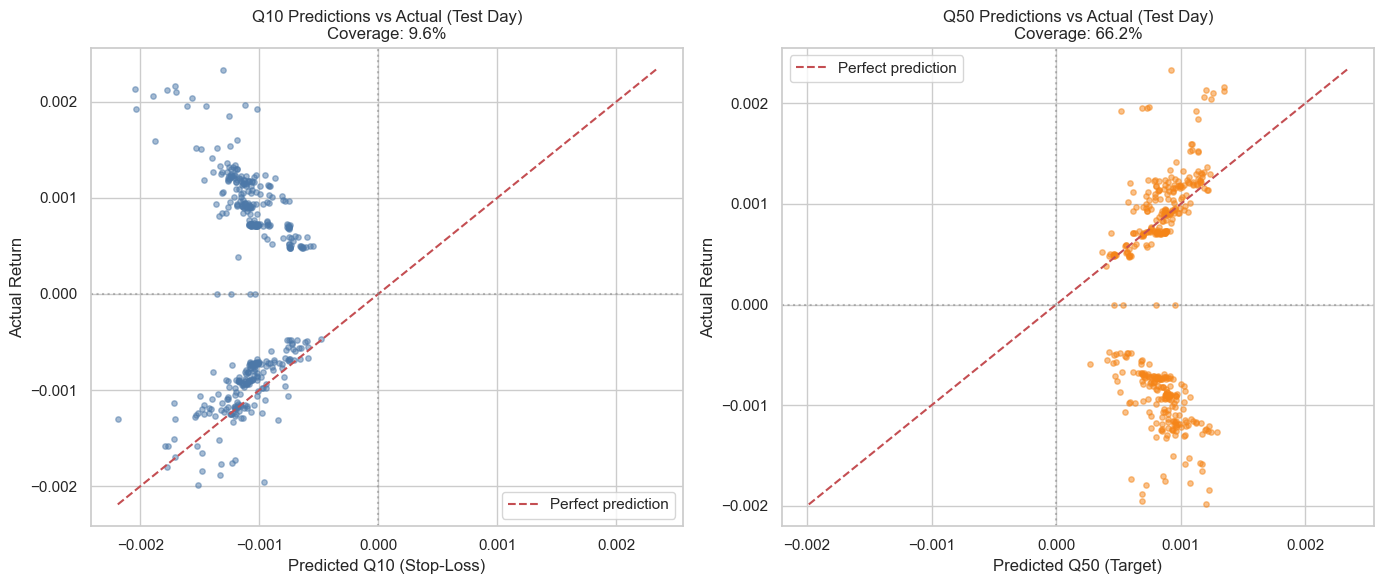

In [15]:
# VISUALIZATION 1: Quantile Predictions vs Actual Returns (Test Day)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Q10
ax = axes[0]
ax.scatter(y_test_pred_q10, y_test, alpha=0.5, s=15, c="#4c78a8")
lims = [min(y_test_pred_q10.min(), y_test.min()), max(y_test_pred_q10.max(), y_test.max())]
ax.plot(lims, lims, 'r--', label="Perfect prediction")
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
ax.axvline(0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Predicted Q10 (Stop-Loss)")
ax.set_ylabel("Actual Return")
ax.set_title(f"Q10 Predictions vs Actual (Test Day)\nCoverage: {coverage_rate(y_test, y_test_pred_q10):.1%}")
ax.legend()

# Q50
ax = axes[1]
ax.scatter(y_test_pred_q50, y_test, alpha=0.5, s=15, c="#f58518")
lims = [min(y_test_pred_q50.min(), y_test.min()), max(y_test_pred_q50.max(), y_test.max())]
ax.plot(lims, lims, 'r--', label="Perfect prediction")
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
ax.axvline(0, color="gray", linestyle=":", alpha=0.5)
ax.set_xlabel("Predicted Q50 (Target)")
ax.set_ylabel("Actual Return")
ax.set_title(f"Q50 Predictions vs Actual (Test Day)\nCoverage: {coverage_rate(y_test, y_test_pred_q50):.1%}")
ax.legend()

plt.tight_layout()
plt.show()

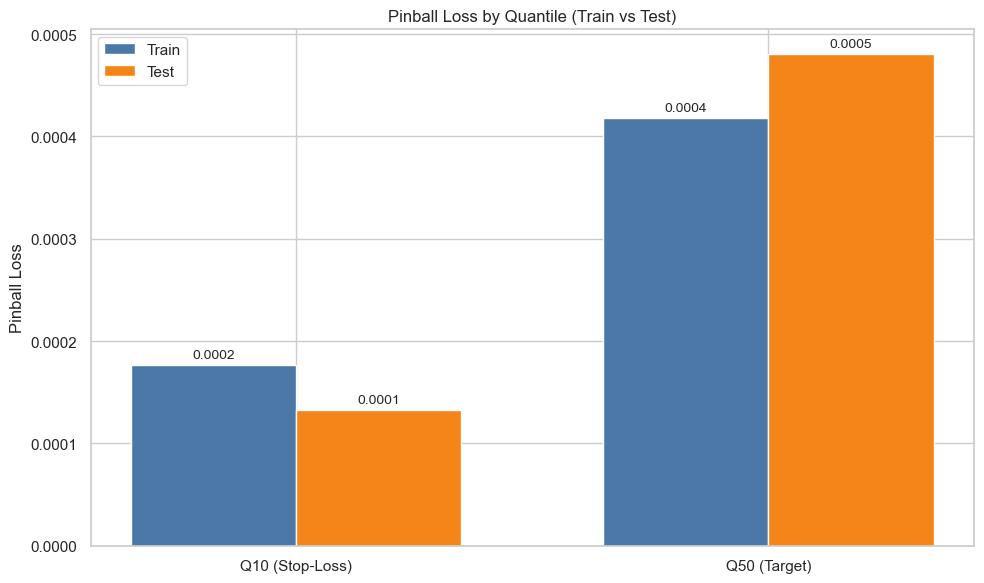

In [16]:
# VISUALIZATION 2: Pinball Loss Comparison (Train vs Test)
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(2)
width = 0.35

train_losses = [train_metrics["quantile_metrics"][0.1]["pinball_loss"],
                train_metrics["quantile_metrics"][0.5]["pinball_loss"]]
test_losses = [test_metrics["quantile_metrics"][0.1]["pinball_loss"],
               test_metrics["quantile_metrics"][0.5]["pinball_loss"]]

bars1 = ax.bar(x - width/2, train_losses, width, label='Train', color='#4c78a8')
bars2 = ax.bar(x + width/2, test_losses, width, label='Test', color='#f58518')

ax.set_ylabel('Pinball Loss')
ax.set_title('Pinball Loss by Quantile (Train vs Test)')
ax.set_xticks(x)
ax.set_xticklabels(['Q10 (Stop-Loss)', 'Q50 (Target)'])
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

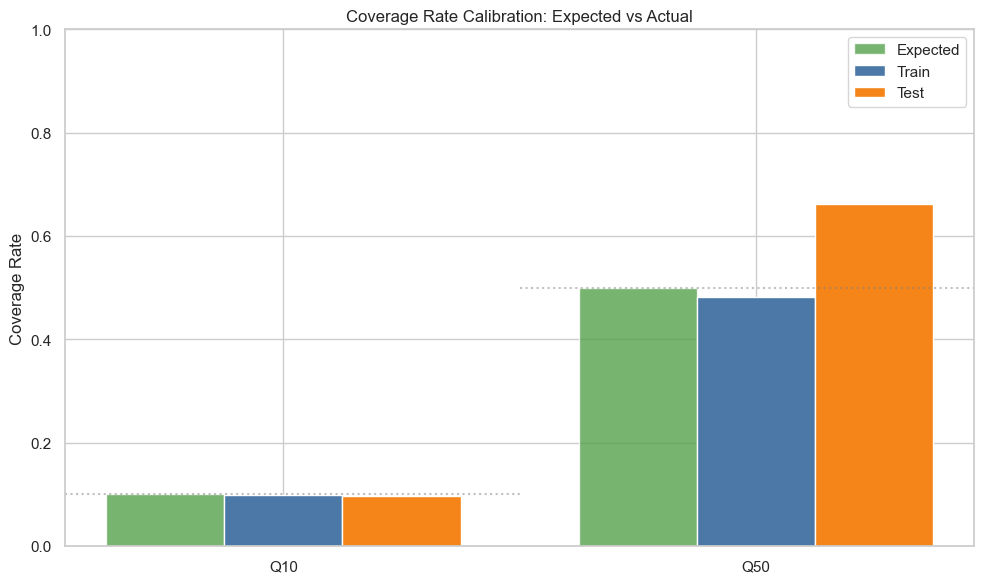

In [17]:
# VISUALIZATION 3: Coverage Rate Calibration
fig, ax = plt.subplots(figsize=(10, 6))

# Expected vs actual coverage
quantiles = [0.1, 0.5]
expected_cov = quantiles
train_cov = [train_metrics["quantile_metrics"][q]["coverage_rate"] for q in quantiles]
test_cov = [test_metrics["quantile_metrics"][q]["coverage_rate"] for q in quantiles]

x = np.arange(len(quantiles))
width = 0.25

ax.bar(x - width, expected_cov, width, label='Expected', color='#54a24b', alpha=0.8)
ax.bar(x, train_cov, width, label='Train', color='#4c78a8')
ax.bar(x + width, test_cov, width, label='Test', color='#f58518')

ax.set_ylabel('Coverage Rate')
ax.set_title('Coverage Rate Calibration: Expected vs Actual')
ax.set_xticks(x)
ax.set_xticklabels(['Q10', 'Q50'])
ax.legend()
ax.set_ylim(0, 1)

# Add reference line at expected levels
for i, q in enumerate(quantiles):
    ax.axhline(q, color='gray', linestyle=':', alpha=0.5, xmin=i/len(quantiles), xmax=(i+1)/len(quantiles))

plt.tight_layout()
plt.show()

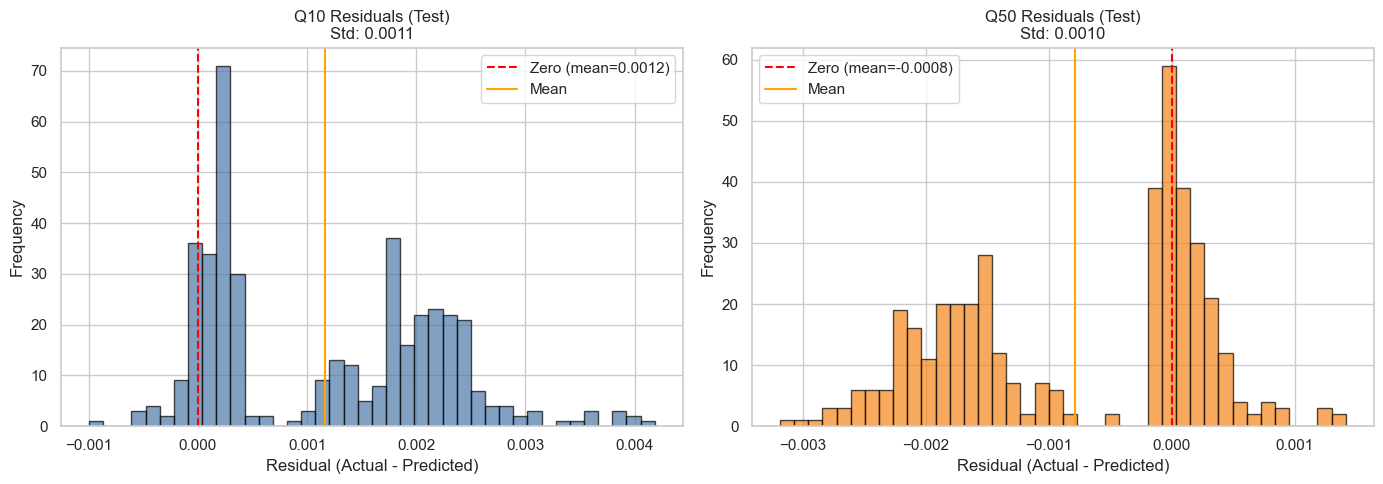

In [18]:
# VISUALIZATION 4: Residual Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q10 residuals
ax = axes[0]
residuals_q10 = y_test - y_test_pred_q10
ax.hist(residuals_q10, bins=40, edgecolor="black", alpha=0.7, color="#4c78a8")
ax.axvline(0, color="red", linestyle="--", label=f"Zero (mean={residuals_q10.mean():.4f})")
ax.axvline(residuals_q10.mean(), color="orange", linestyle="-", label=f"Mean")
ax.set_xlabel("Residual (Actual - Predicted)")
ax.set_ylabel("Frequency")
ax.set_title(f"Q10 Residuals (Test)\nStd: {residuals_q10.std():.4f}")
ax.legend()

# Q50 residuals
ax = axes[1]
residuals_q50 = y_test - y_test_pred_q50
ax.hist(residuals_q50, bins=40, edgecolor="black", alpha=0.7, color="#f58518")
ax.axvline(0, color="red", linestyle="--", label=f"Zero (mean={residuals_q50.mean():.4f})")
ax.axvline(residuals_q50.mean(), color="orange", linestyle="-", label=f"Mean")
ax.set_xlabel("Residual (Actual - Predicted)")
ax.set_ylabel("Frequency")
ax.set_title(f"Q50 Residuals (Test)\nStd: {residuals_q50.std():.4f}")
ax.legend()

plt.tight_layout()
plt.show()

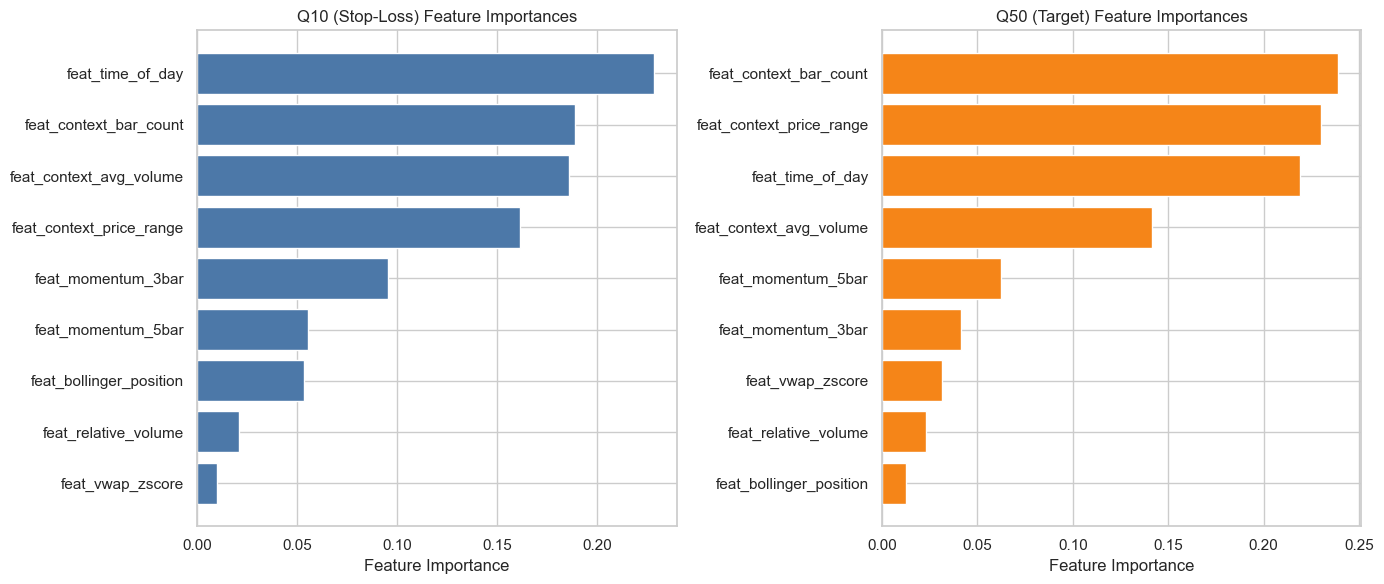


Feature Importances (sorted by Q50):


,Feature,Q10 Importance,Q50 Importance
6,feat_context_bar_count,0.188940,0.239030
8,feat_context_price_range,0.161700,0.229936
5,feat_time_of_day,0.228373,0.218774
7,feat_context_avg_volume,0.186101,0.141463
3,feat_momentum_5bar,0.055242,0.062182
2,feat_momentum_3bar,0.095358,0.041425
0,feat_vwap_zscore,0.009967,0.031445
4,feat_relative_volume,0.020914,0.023077
1,feat_bollinger_position,0.053404,0.012666


In [19]:
# VISUALIZATION 5: Feature Importances
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Q10 feature importances
ax = axes[0]
imp_q10 = pd.DataFrame({
    "feature": feature_names,
    "importance": model_q10.feature_importances_,
}).sort_values("importance", ascending=True)

ax.barh(imp_q10["feature"], imp_q10["importance"], color="#4c78a8")
ax.set_xlabel("Feature Importance")
ax.set_title("Q10 (Stop-Loss) Feature Importances")

# Q50 feature importances
ax = axes[1]
imp_q50 = pd.DataFrame({
    "feature": feature_names,
    "importance": model_q50.feature_importances_,
}).sort_values("importance", ascending=True)

ax.barh(imp_q50["feature"], imp_q50["importance"], color="#f58518")
ax.set_xlabel("Feature Importance")
ax.set_title("Q50 (Target) Feature Importances")

plt.tight_layout()
plt.show()

# Print as table
print("\nFeature Importances (sorted by Q50):")
imp_combined = pd.DataFrame({
    "Feature": feature_names,
    "Q10 Importance": model_q10.feature_importances_,
    "Q50 Importance": model_q50.feature_importances_,
}).sort_values("Q50 Importance", ascending=False)
display(imp_combined)

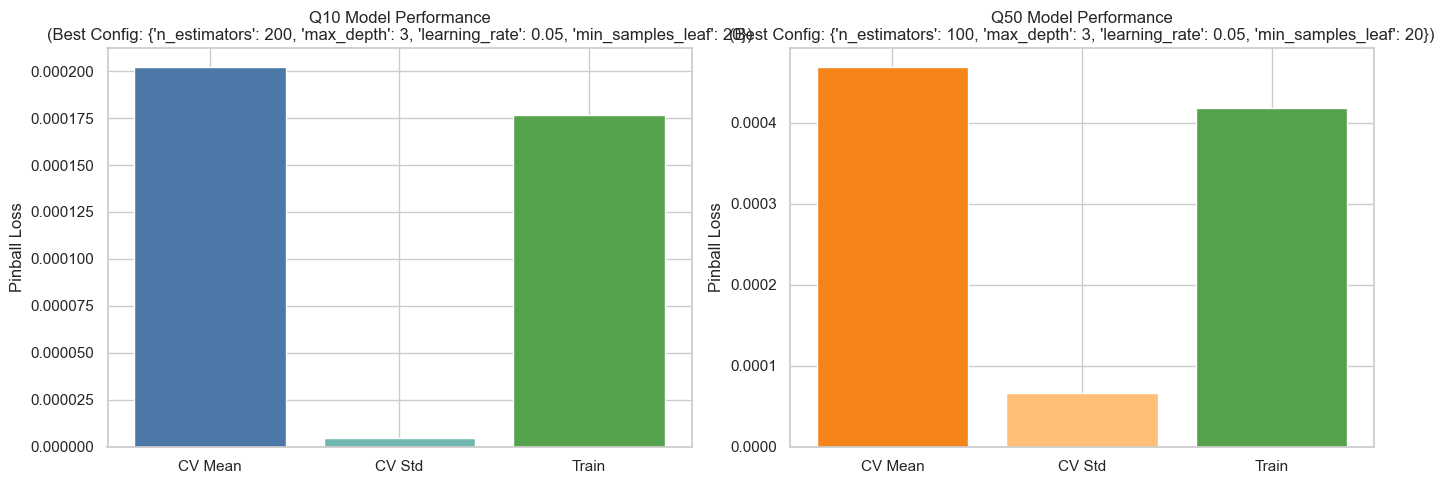

In [20]:
# VISUALIZATION 6: LODO CV Performance Across Folds
# Extract per-fold performance from CV results

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Q10 CV results
ax = axes[0]
cv_q10_df = pd.DataFrame(summary_q10["grid_results"])
best_q10 = summary_q10["best_params"]
cv_q10_best = cv_q10_df[
    (cv_q10_df["n_estimators"] == best_q10["n_estimators"]) &
    (cv_q10_df["max_depth"] == best_q10["max_depth"]) &
    (cv_q10_df["learning_rate"] == best_q10["learning_rate"]) &
    (cv_q10_df["min_samples_leaf"] == best_q10["min_samples_leaf"])
].iloc[0]

# Create violin plot of CV losses for best config
ax.bar(["CV Mean", "CV Std", "Train"], 
       [cv_q10_best["cv_mean_pinball"], cv_q10_best["cv_std_pinball"], summary_q10["train_pinball"]],
       color=["#4c78a8", "#72b7b2", "#54a24b"])
ax.set_ylabel("Pinball Loss")
ax.set_title(f"Q10 Model Performance\n(Best Config: {best_q10})")

# Q50 CV results
ax = axes[1]
cv_q50_df = pd.DataFrame(summary_q50["grid_results"])
best_q50 = summary_q50["best_params"]
cv_q50_best = cv_q50_df[
    (cv_q50_df["n_estimators"] == best_q50["n_estimators"]) &
    (cv_q50_df["max_depth"] == best_q50["max_depth"]) &
    (cv_q50_df["learning_rate"] == best_q50["learning_rate"]) &
    (cv_q50_df["min_samples_leaf"] == best_q50["min_samples_leaf"])
].iloc[0]

ax.bar(["CV Mean", "CV Std", "Train"], 
       [cv_q50_best["cv_mean_pinball"], cv_q50_best["cv_std_pinball"], summary_q50["train_pinball"]],
       color=["#f58518", "#ffbf79", "#54a24b"])
ax.set_ylabel("Pinball Loss")
ax.set_title(f"Q50 Model Performance\n(Best Config: {best_q50})")

plt.tight_layout()
plt.show()

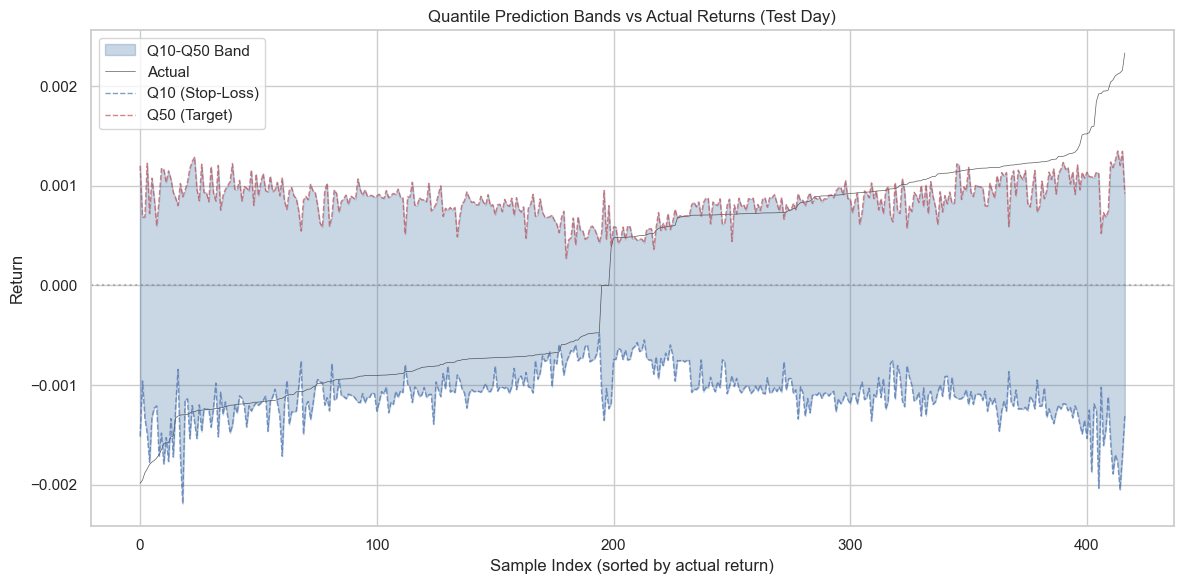

In [21]:
# VISUALIZATION 7: Prediction Bands Over Sorted Actual Values
fig, ax = plt.subplots(figsize=(12, 6))

# Sort by actual return for visualization
sort_idx = np.argsort(y_test)
y_sorted = y_test[sort_idx]
q10_sorted = y_test_pred_q10[sort_idx]
q50_sorted = y_test_pred_q50[sort_idx]

x_axis = np.arange(len(y_sorted))

ax.fill_between(x_axis, q10_sorted, q50_sorted, alpha=0.3, color="#4c78a8", label="Q10-Q50 Band")
ax.plot(x_axis, y_sorted, 'k-', alpha=0.7, linewidth=0.5, label="Actual")
ax.plot(x_axis, q10_sorted, 'b--', alpha=0.7, linewidth=1, label="Q10 (Stop-Loss)")
ax.plot(x_axis, q50_sorted, 'r--', alpha=0.7, linewidth=1, label="Q50 (Target)")

ax.set_xlabel("Sample Index (sorted by actual return)")
ax.set_ylabel("Return")
ax.set_title("Quantile Prediction Bands vs Actual Returns (Test Day)")
ax.legend(loc="upper left")
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()

## 7. Summary Tables

In [22]:
# GBM Configuration Summary
config_summary = pd.DataFrame([
    {"Parameter": "Model Type", "Q10 (Stop-Loss)": "GradientBoostingRegressor", "Q50 (Target)": "GradientBoostingRegressor"},
    {"Parameter": "Loss Function", "Q10 (Stop-Loss)": "quantile (alpha=0.1)", "Q50 (Target)": "quantile (alpha=0.5)"},
    {"Parameter": "n_estimators", "Q10 (Stop-Loss)": best_q10["n_estimators"], "Q50 (Target)": best_q50["n_estimators"]},
    {"Parameter": "max_depth", "Q10 (Stop-Loss)": best_q10["max_depth"], "Q50 (Target)": best_q50["max_depth"]},
    {"Parameter": "learning_rate", "Q10 (Stop-Loss)": best_q10["learning_rate"], "Q50 (Target)": best_q50["learning_rate"]},
    {"Parameter": "min_samples_leaf", "Q10 (Stop-Loss)": best_q10["min_samples_leaf"], "Q50 (Target)": best_q50["min_samples_leaf"]},
    {"Parameter": "Train Samples", "Q10 (Stop-Loss)": X_train.shape[0], "Q50 (Target)": X_train.shape[0]},
    {"Parameter": "Test Samples", "Q10 (Stop-Loss)": X_test.shape[0], "Q50 (Target)": X_test.shape[0]},
    {"Parameter": "Features", "Q10 (Stop-Loss)": X_train.shape[1], "Q50 (Target)": X_train.shape[1]},
])

print("\nGBM Model Configuration:")
display(config_summary)


GBM Model Configuration:


,Parameter,Q10 (Stop-Loss),Q50 (Target)
0,Model Type,GradientBoostingRegressor,GradientBoostingRegressor
1,Loss Function,quantile (alpha=0.1),quantile (alpha=0.5)
2,n_estimators,200,100
3,max_depth,3,3
4,learning_rate,0.05,0.05
5,min_samples_leaf,20,20
6,Train Samples,1424,1424
7,Test Samples,417,417
8,Features,9,9


In [23]:
# Performance Summary
perf_summary = pd.DataFrame([
    {
        "Metric": "CV Mean Pinball Loss",
        "Q10 (Stop-Loss)": f"{summary_q10['cv_mean_pinball']:.6f}",
        "Q50 (Target)": f"{summary_q50['cv_mean_pinball']:.6f}",
    },
    {
        "Metric": "CV Std Pinball Loss",
        "Q10 (Stop-Loss)": f"{summary_q10['cv_std_pinball']:.6f}",
        "Q50 (Target)": f"{summary_q50['cv_std_pinball']:.6f}",
    },
    {
        "Metric": "Train Pinball Loss",
        "Q10 (Stop-Loss)": f"{summary_q10['train_pinball']:.6f}",
        "Q50 (Target)": f"{summary_q50['train_pinball']:.6f}",
    },
    {
        "Metric": "Test Pinball Loss",
        "Q10 (Stop-Loss)": f"{test_metrics['quantile_metrics'][0.1]['pinball_loss']:.6f}",
        "Q50 (Target)": f"{test_metrics['quantile_metrics'][0.5]['pinball_loss']:.6f}",
    },
    {
        "Metric": "Test Coverage Rate",
        "Q10 (Stop-Loss)": f"{test_metrics['quantile_metrics'][0.1]['coverage_rate']:.3f}",
        "Q50 (Target)": f"{test_metrics['quantile_metrics'][0.5]['coverage_rate']:.3f}",
    },
    {
        "Metric": "Expected Coverage",
        "Q10 (Stop-Loss)": "0.100",
        "Q50 (Target)": "0.500",
    },
    {
        "Metric": "Calibration Error",
        "Q10 (Stop-Loss)": f"{test_metrics['quantile_metrics'][0.1]['calibration_error']:.3f}",
        "Q50 (Target)": f"{test_metrics['quantile_metrics'][0.5]['calibration_error']:.3f}",
    },
])

print("\nGBM Performance Summary:")
display(perf_summary)


GBM Performance Summary:


,Metric,Q10 (Stop-Loss),Q50 (Target)
0,CV Mean Pinball Loss,0.000202,0.000469
1,CV Std Pinball Loss,0.000005,0.000066
2,Train Pinball Loss,0.000177,0.000418
3,Test Pinball Loss,0.000133,0.000481
4,Test Coverage Rate,0.096,0.662
5,Expected Coverage,0.100,0.500
6,Calibration Error,0.004,0.162


## 8. Save Artifacts

In [24]:
# Save models and config
models_dict = {
    "q10": model_q10,
    "q50": model_q50,
}

config = {
    "rf_proba_threshold": RF_PROBA_THRESHOLD,
    "feature_names": feature_names,
    "train_days": [str(d) for d in train_days],
    "test_day": str(test_day),
    "q10_config": {
        "quantile": 0.1,
        "best_params": summary_q10["best_params"],
        "cv_mean_pinball": summary_q10["cv_mean_pinball"],
        "cv_std_pinball": summary_q10["cv_std_pinball"],
        "train_pinball": summary_q10["train_pinball"],
    },
    "q50_config": {
        "quantile": 0.5,
        "best_params": summary_q50["best_params"],
        "cv_mean_pinball": summary_q50["cv_mean_pinball"],
        "cv_std_pinball": summary_q50["cv_std_pinball"],
        "train_pinball": summary_q50["train_pinball"],
    },
    "test_metrics": test_metrics,
    "preprocessing": "StandardScaler (fit on train days)",
}

paths = save_artifacts(models_dict, scaler, config, outdir="models", logger=logger)
print("\nSaved artifacts:")
for k, v in paths.items():
    print(f"  {k}: {v}")

2025-11-28 14:40:04,519 [INFO] Saved GBM model to models\gbm_q10.joblib
2025-11-28 14:40:04,527 [INFO] Saved GBM model to models\gbm_q50.joblib
2025-11-28 14:40:04,530 [INFO] Saved scaler to models\gbm_scaler.joblib
2025-11-28 14:40:04,532 [INFO] Saved config to models\gbm_config.json



Saved artifacts:
  model_q10: models\gbm_q10.joblib
  model_q50: models\gbm_q50.joblib
  scaler: models\gbm_scaler.joblib
  config: models\gbm_config.json


In [25]:
# Save predictions to parquet
from pathlib import Path

gbm_data_dir = Path("data/gbm")
gbm_data_dir.mkdir(parents=True, exist_ok=True)

# Combine predictions with original data
df_train_out = data["df_train"].copy()
df_train_out["gbm_pred_q10"] = y_train_pred_q10
df_train_out["gbm_pred_q50"] = y_train_pred_q50

df_test_out = data["df_test"].copy()
df_test_out["gbm_pred_q10"] = y_test_pred_q10
df_test_out["gbm_pred_q50"] = y_test_pred_q50

df_all_out = pd.concat([df_train_out, df_test_out], ignore_index=True)

predictions_path = gbm_data_dir / "gbm_predictions.parquet"
df_all_out.to_parquet(predictions_path, index=False)
print(f"Saved GBM predictions to {predictions_path}")
print(f"  Total rows: {len(df_all_out):,}")
print(f"  Columns: {list(df_all_out.columns)}")

Saved GBM predictions to data\gbm\gbm_predictions.parquet
  Total rows: 1,841
  Columns: ['ticker', 'date', 't', 't_end', 'gmm_loglik', 'gmm_is_candidate', 'gmm_component', 'label', 'feat_vwap_zscore', 'feat_bollinger_position', 'feat_momentum_3bar', 'feat_momentum_5bar', 'feat_relative_volume', 'feat_time_of_day', 'feat_context_bar_count', 'feat_context_avg_volume', 'feat_context_price_range', 'day', 'y', 'rf_proba_reversion', 'ewm_std', 'forward_return', 'gbm_pred_q10', 'gbm_pred_q50']


In [26]:
print("\n" + "="*60)
print("GBM QUANTILE REGRESSION EXIT MODEL - COMPLETE")
print("="*60)
print(f"\nModels trained: Q10 (stop-loss) and Q50 (target)")
print(f"Train samples: {X_train.shape[0]:,} | Test samples: {X_test.shape[0]:,}")
print(f"\nTest Performance:")
print(f"  Q10 Coverage: {test_metrics['quantile_metrics'][0.1]['coverage_rate']:.1%} (expected 10.0%)")
print(f"  Q50 Coverage: {test_metrics['quantile_metrics'][0.5]['coverage_rate']:.1%} (expected 50.0%)")
print(f"\nArtifacts saved to: models/")
print(f"Predictions saved to: data/gbm/gbm_predictions.parquet")


GBM QUANTILE REGRESSION EXIT MODEL - COMPLETE

Models trained: Q10 (stop-loss) and Q50 (target)
Train samples: 1,424 | Test samples: 417

Test Performance:
  Q10 Coverage: 9.6% (expected 10.0%)
  Q50 Coverage: 66.2% (expected 50.0%)

Artifacts saved to: models/
Predictions saved to: data/gbm/gbm_predictions.parquet
